In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp

In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

In [3]:
dataset_path = 'asl_alphabet'

In [6]:
def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)
    
    if result.multi_hand_landmarks:
        landmarks = result.multi_hand_landmarks[0]
        # Extract x, y coordinates
        landmark_array = np.array([[landmark.x, landmark.y] for landmark in landmarks.landmark])
        
        # Center landmarks (subtract mean)
        x_mean, y_mean = np.mean(landmark_array, axis=0)
        centered_landmarks = landmark_array - [x_mean, y_mean]
        
        # Scale landmarks (divide by max distance from center)
        max_dist = np.max(np.sqrt(np.sum(centered_landmarks**2, axis=1)))
        if max_dist > 0:  # Avoid division by zero
            scaled_landmarks = centered_landmarks / max_dist
        else:
            scaled_landmarks = centered_landmarks
        
        return scaled_landmarks.flatten()
    return None

def load_and_process_images(path):
    features = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                landmarks = extract_landmarks(img_path)
                if landmarks is not None:
                    features.append(landmarks)
                    labels.append(label)
    return np.array(features), np.array(labels)

X, y = load_and_process_images(dataset_path)

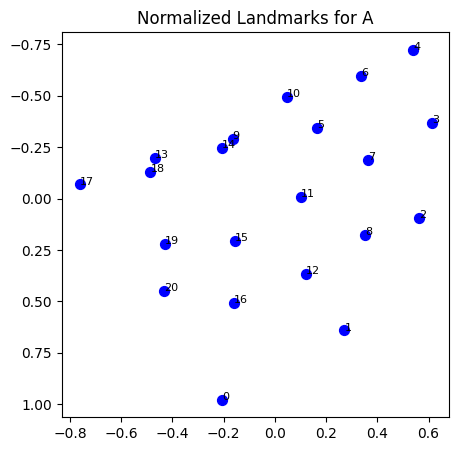

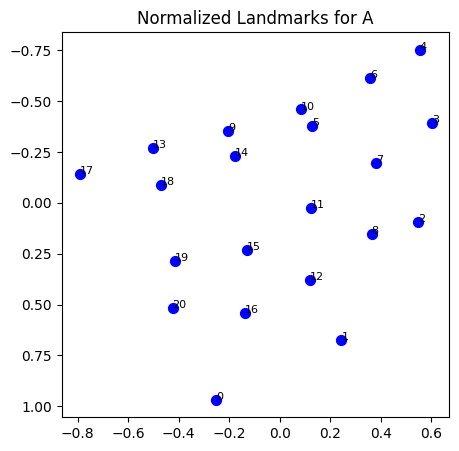

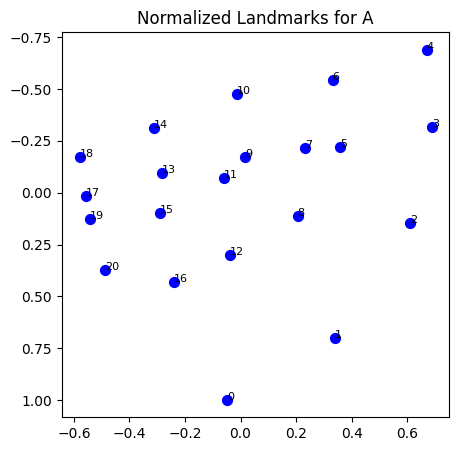

In [7]:
def plot_landmarks(landmarks, label):
    plt.figure(figsize=(5, 5))
    x_coords = landmarks[0::2]
    y_coords = landmarks[1::2]
    plt.scatter(x_coords, y_coords, c='blue', s=50)
    for i in range(len(x_coords)):
        plt.text(x_coords[i], y_coords[i], str(i), fontsize=8)
    plt.title(f"Normalized Landmarks for {label}")
    plt.gca().invert_yaxis()
    plt.show()

for i in range(min(3, len(X))):
    plot_landmarks(X[i], y[i])

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (50941, 42) (50941,)
Validation set: (6367, 42) (6367,)
Test set: (6368, 42) (6368,)


In [9]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)
np.save('label_encoder_classes.npy', le.classes_)

hands.close()